<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Py_trodes/PyTrodes_Pipeline_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
New Python Based Pipeline for Trodes
"""

'\nNew Python Based Pipeline for Trodes\n'

In [2]:
""" Generate RAW_LFP Binaries from *.rec files"""
""" Import RAW_LFP """
""" Import XY_position Data """
""" Find Ripples """
""" Map Channels """
""" Finde APs """
""" Find IIS """


' Find IIS '

In [3]:
import os
import subprocess
import numpy as np
trodes_dat_reader_loc = 'C:/Users/dennis.tabuena/Desktop/_SPIKE_GADGETS/Trodes_2-5-1_Windows64/Trodes_2-5-1_Windows64/Resources/TrodesToPython'
os.chdir(trodes_dat_reader_loc)
import readTrodesExtractedDataFile3 as trodes



def read_npy_metadata(npy_filename):
    with open(npy_filename, 'rb') as f:
        version = np.lib.format.read_magic(f)
        np.lib.format._check_version(version)
        shape, fortran_order, dtype = np.lib.format.read_array_header_1_0(f)
        offset = f.tell()
    return shape, dtype, offset

def load_npy_to_memmap(npy_filename):
    shape, dtype, offset = read_npy_metadata(npy_filename)
    return np.memmap(npy_filename, dtype=dtype, mode='r', offset=offset, shape=shape)

def display_filter(fir_coeff,rate):
    # Plot the frequency response of the filter
    w, h = sci.signal.freqz(fir_coeff, worN=8000)
    fig,ax=plt.subplots(1,2,figsize=(4,2),dpi=300)
    ax[0].plot(fir_coeff)
    ax[0].set_title('Coefficients')
    ax[1].plot(0.5 * rate * w / np.pi, np.abs(h), 'b')
    ax[1].set_title('FIR Filter Frequency Response')
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel('Gain')
    plt.grid()
    plt.show()



In [4]:
""" Generate RAW_LFP Binaries from *.rec files"""
dest_dir = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\TRODE_EXPORTS\RAW_DATA'
export_func_location = r'C:\Users\dennis.tabuena\Desktop\_SPIKE_GADGETS\Trodes_2-5-1_Windows64\Trodes_2-5-1_Windows64\trodesexport.exe'
dot_rec_file_loc = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\Test_Emily\AngelfoodCake01\AngelfoodCake01.rec'
full_cmd_raw = ' '.join([export_func_location, '-raw',
                    '-rec ', dot_rec_file_loc,
                    '-userawrefs', str(0),
                    '-outputdirectory', dest_dir])
# export_report = subprocess.run(full_cmd_raw)



In [5]:
""" Import RAW_LFP """
my_analysis_dir = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\ReAnalyze'

dot_dat_file_loc = r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\TRODE_EXPORTS\RAW_DATA\AngelfoodCake01.raw\AngelfoodCake01.raw_group0.dat'
animal_session = os.path.basename(dot_rec_file_loc).replace('.rec','')
dot_dat_data = trodes.readTrodesExtractedDataFile(dot_dat_file_loc)
voltage_scaling = float(dot_dat_data['voltage_scaling'])
default_sample_rate = dot_dat_data['clockrate']
num_samples = dot_dat_data['data']['voltage'].shape[0]
num_channels = dot_dat_data['data']['voltage'].shape[1]

os.chdir(r'\\hive.gladstone.internal\Huang-LFP\TabuenaLFP\ReAnalyze')

memmap_filename = os.path.join(my_analysis_dir,'lfp_disk_array.dat')
lfp_disk_array = np.memmap(memmap_filename, dtype='float16', mode='w+', shape=(num_samples,num_channels))
lfp_disk_array = dot_dat_data['data']['voltage'].astype('float16')
lfp_disk_array*=voltage_scaling
raw_npy_filename = os.path.join(my_analysis_dir,animal_session+'_raw_lfp.npy')
np.save(raw_npy_filename, lfp_disk_array)


In [10]:
dot_dat_data['data']=np.nan

In [14]:
"""
DOWN SAMPLE & SAVE
"""
lfp_disk_array = load_npy_to_memmap(raw_npy_filename)
default_sample_rate = 30000
downsampled_rate = 5000
downsample_factor = default_sample_rate/downsampled_rate
downsample_indicies = np.arange(0,lfp_disk_array.shape[0],downsample_factor,dtype='int')
ds_array=lfp_disk_array[downsample_indicies,:]
downsamp_npy_filename = raw_npy_filename.replace('raw', 'downsamp')
np.save(downsamp_npy_filename, ds_array)
del(ds_array)
np.save(animal_session+'_downsampled_rate.npy',downsampled_rate)
lfp_disk_array = load_npy_to_memmap(downsamp_npy_filename)

In [24]:
"""
BAND PASS FOR RIPPLES
"""
import scipy as sci
import matplotlib.pyplot as plt
downsampled_rate = int(np.load(animal_session+'_downsampled_rate.npy'))
passband = [150, 250] #(150-250 Hz)
num_coefficients = 1200
fir_coeff = sci.signal.firwin(num_coefficients, passband, width=10, window='hamming', pass_zero='bandpass', scale=True, fs=downsampled_rate)

''' Apply the FIR filter using filtfilt for zero-phase filtering across all channels '''
lfp_disk_array = sci.signal.filtfilt(fir_coeff, 1.0, lfp_disk_array, axis=0)

In [37]:
print(lfp_disk_array[0:3,:])

[[ 2.46888462e-03 -1.28586566e-02 -2.33699774e-02  4.80947846e-03
  -2.86238555e-03  4.63919472e-04  1.42514994e-02 -1.41602482e-03
  -8.53518677e-04  2.12966655e-03  4.89547166e-03  2.43978700e-03
   2.82463920e-03 -3.26862600e-03 -2.77547454e-02 -8.29952868e-03
  -3.30221239e-03  3.26345445e-03 -8.32156714e-04  4.10858889e-03
  -3.91154904e-03  2.58386291e-02 -1.94246653e-04  9.45862156e-03
   1.10619550e-02  6.27982689e-03  3.30247247e-03  4.59184518e-03
   1.56471290e-03  2.41605862e-03 -1.12398130e-02  4.06938178e-02]
 [ 2.04780085e+01  1.93637229e+01  1.72173807e+01  1.97236595e+01
   1.95579879e+01  2.09241682e+01  2.03054791e+01  1.58727843e+01
   1.82095745e+01  1.93270494e+01  2.01651166e+01  1.94106916e+01
   2.36081497e+01  9.67961483e+00  6.03324985e+00  8.97239158e+00
   1.69320970e+01  1.94216259e+01  2.02548711e+01  1.26435625e+01
   7.35336018e+00  2.48012754e-01  9.13438107e+00  1.22285321e+01
   1.79522523e+01  2.18297465e+01  2.66290676e+01  1.34348763e+01
  -2.4581

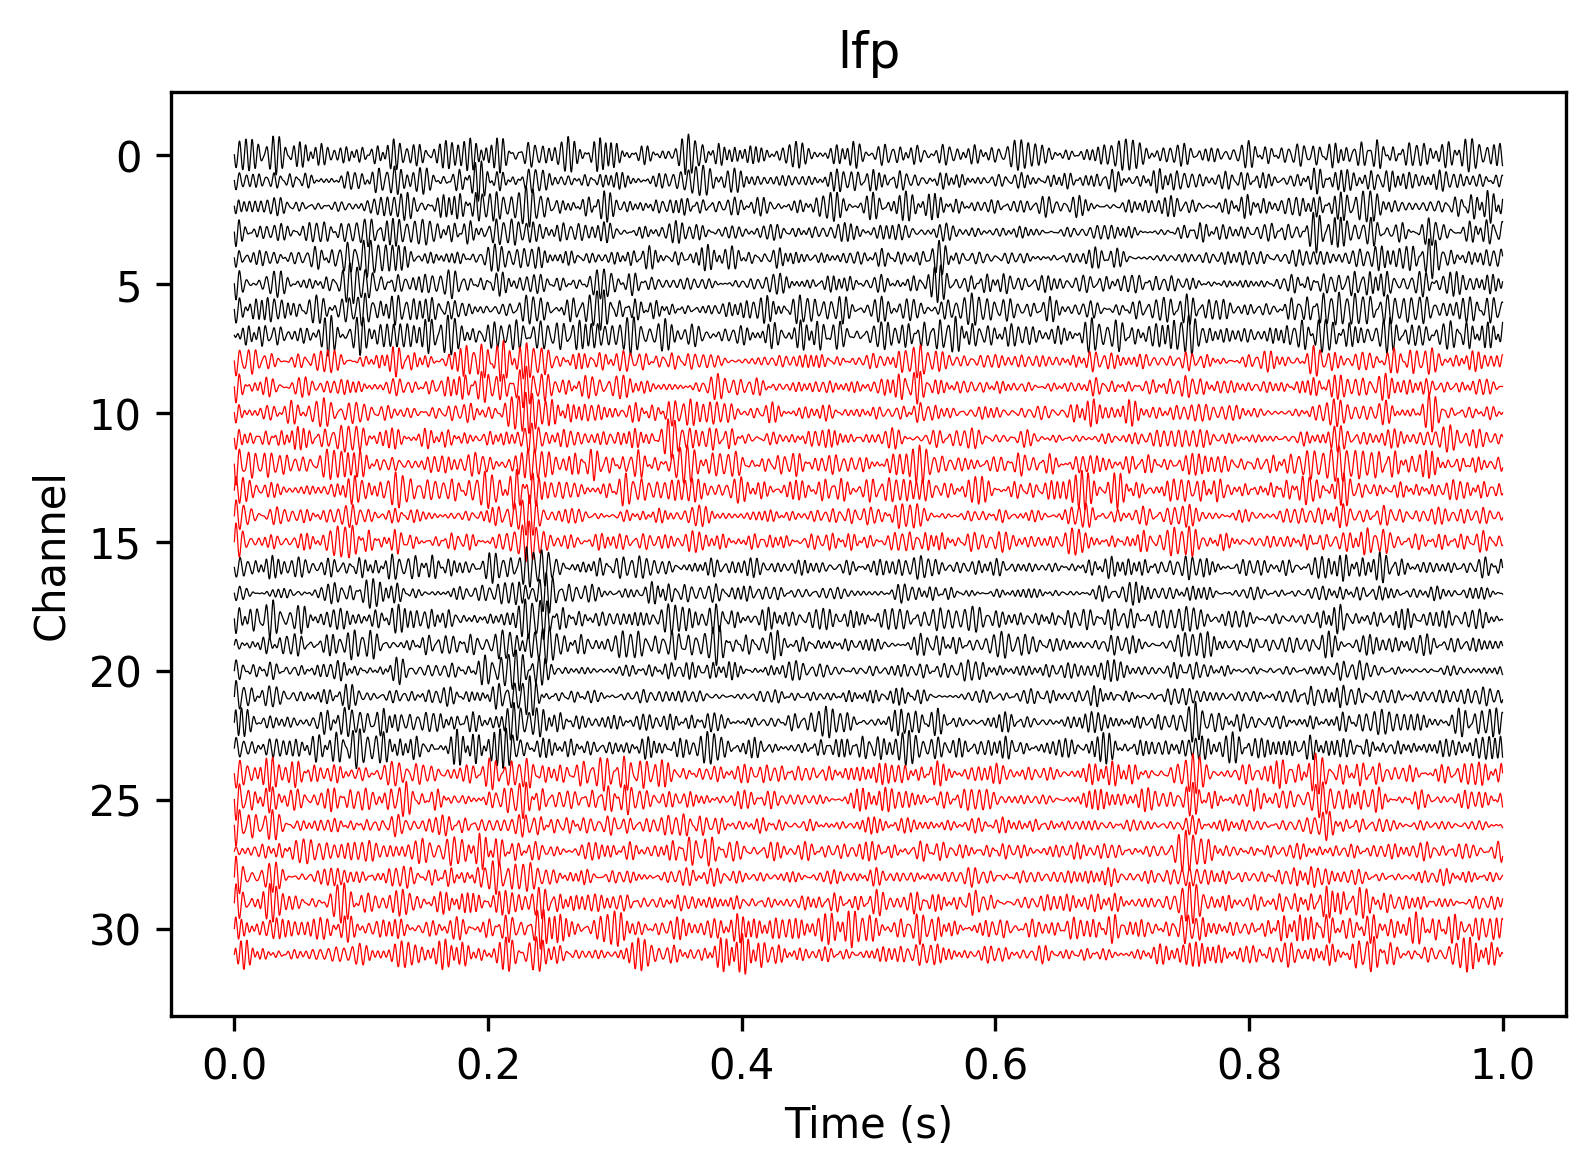

In [42]:
def plot_sample_wave(lfp,sample_rate,times=[0,1]):
    colors = ['k']*8 + ['r']*8 + ['k']*8 + ['r']*8
    tic_indicies = np.arange(times[0]*sample_rate,times[1]*sample_rate)
    time_sec = tic_indicies/sample_rate
    waveform = lfp[tic_indicies,:]
    waveform = waveform - np.expand_dims(np.mean(waveform,axis=1),axis=-1)
    fig,ax = plt.subplots(figsize=(6,4),dpi=300)
    waveform = waveform/np.max(np.abs(waveform),axis=0) * .8
    # Filtered signal
    for ch in np.arange(waveform.shape[1]):
        ax.plot(time_sec,waveform[:,ch]+ch,linewidth=.3,color = colors[ch])
        ax.set_title('lfp')
    ax.invert_yaxis()
    ax.set_ylabel('Channel')
    ax.set_xlabel('Time (s)')

plot_sample_wave(lfp_disk_array,downsampled_rate)

In [ ]:
SR = 30000
x = np.random.randint(0,lfp_disk_array.shape[0])
t_wind  = [x,x+10*SR]
t_ind = np.arange(t_wind[0],t_wind[1])

from matplotlib import pyplot as plt
v_samp = lfp_disk_array[t_ind,:]
v_samp = v_samp / np.max(np.abs(v_samp),axis=0) *.75
ch = np.arange(0,32)+1
v_samp = (v_samp.transpose()-v_samp[:,24]).transpose()

colors = ['k']*8 + ['r']*8 + ['k']*8 + ['r']*8
time_sec = (t_ind-t_ind[0])/SR
fig,ax = plt.subplots(figsize=(6,2),dpi=300)
for ch in np.arange(v_samp.shape[1]):
    _ = ax.plot(time_sec,v_samp[:,ch]+ch,linewidth=.1,color = colors[ch])
ax.invert_yaxis()
ax.set_title('30khz #No Filters')
ax.set_ylabel('Channel')
ax.set_xlabel('Time (s)')